# 1 Hz pollutant data peak matching

In [1]:
#dataframe, plotting, and statistical libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt
from scipy import stats
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset

import itertools as it
from matplotlib.dates import DateFormatter
timeFormat = DateFormatter('%H:%M')
import statsmodels.api as sm

In [38]:
plt.style.use('mpl_config.mplstyle')

## Import AE33 and ABCD data

In [3]:
fname = '/Users/jdabutler/Documents/+github/rx burn/unaligned AE33 + ABCD/'
AE33hz = pd.read_csv(fname+'ground_AE33_1Hz.csv')
AE33hz.datetime = pd.to_datetime(AE33hz.datetime)
#AE33hz.set_index('datetime',inplace=True)

ABCDhz = pd.read_csv(fname+'ground_ABCD_1Hz.csv')
ABCDmin = pd.read_csv(fname+'ground_ABCD_1min.csv')

ABCDhz.datetime = pd.to_datetime(ABCDhz.datetime)
ABCDmin.datetime = pd.to_datetime(ABCDmin.datetime)

# AE33 sample only dataframe
dfs = AE33hz[AE33hz.Status.isin([0,128])]

## Import gas data

In [4]:
fname = '/Users/jdabutler/Documents/+github/rx burn/unaligned gases/'

# Load 1 Hz data
NOx_hz = pd.read_csv(fname+'/NOx_1Hz.csv')
CO_hz = pd.read_csv(fname+'/CO_1Hz.csv')
CO2H_hz = pd.read_csv(fname+'/CO2_1Hz_Horiba.csv')
CO2L_hz = pd.read_csv(fname+'/CO2_1Hz_LICOR.csv')

NOx_hz.dropna(axis=1,inplace=True,how='all')
CO_hz.dropna(axis=1,inplace=True,how='all')
CO2H_hz.dropna(axis=1,inplace=True,how='all')
CO2L_hz.dropna(axis=1,inplace=True,how='all')

NOx_hz['datetime'] = NOx_hz.Date +' '+ NOx_hz.Time
CO_hz['datetime'] = CO_hz.Date + ' ' + CO_hz.Time
CO2H_hz['datetime'] = CO2H_hz.Date + ' ' + CO2H_hz.Time
CO2L_hz['datetime'] = CO2L_hz.Date + ' ' + CO2L_hz.Time

# set datetime as index
NOx_hz.datetime = pd.to_datetime(NOx_hz.datetime)
CO_hz.datetime = pd.to_datetime(CO_hz.datetime)
CO2H_hz.datetime = pd.to_datetime(CO2H_hz.datetime)
CO2L_hz.datetime = pd.to_datetime(CO2L_hz.datetime)

CO_hz.dropna(axis=0,how='all',inplace=True)

#NOx_min = pd.read_csv(fname+'/NOx_1min.csv')
#CO_min = pd.read_csv(fname+'/CO_1min.csv')
#NOx_min.dropna(axis=1,inplace=True,how='all')
#CO_min.dropna(axis=1,inplace=True,how='all')
#CO_min.rename({'Time':'datetime'},axis=1,inplace=True)
#NOx_min.rename({'Time':'datetime'},axis=1,inplace=True)
#CO_min.datetime = pd.to_datetime(CO_min.datetime)
#NOx_min.datetime = pd.to_datetime(NOx_min.datetime)

# Functions

In [6]:
def pearson(X,Y):
    mask = ~np.isnan(X) & ~np.isnan(Y)
    X = X[mask]
    Y = Y[mask]
    p = stats.pearsonr(X,Y)
    return p[0]


def linRegConstCI(X,Y):
    mask = ~np.isnan(X) & ~np.isnan(Y)
    X = X[mask]
    Y = Y[mask]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    r = model.fit()
    
    s = r.params[1]
    b = r.params[0]
    r2 = r.rsquared

    s_u = r.conf_int().values[1,0]
    s_l = r.conf_int().values[1,1]
    b_u = r.conf_int().values[0,0]
    b_l = r.conf_int().values[0,1]
    return s,b,r2,s_l,s_u,b_l,b_u

# Run offset Loops at 1 Hz for ABCD versus AE33

In [7]:
bound = 121
seconds = np.arange(0,bound)
offset = pd.DataFrame(columns=['delta','pearsonHz','pearson10','pearsonM'])

#negative time offset
for s in seconds:
    ABCDtemp = ABCDhz.copy()
    
    mask = (ABCDtemp.BC < -50) | (ABCDtemp.BC > 1000)
    ABCDtemp.loc[mask,'BC'] = np.nan
    
    new_datetime = ABCDtemp.datetime - DateOffset(seconds = float(s))
    ABCDtemp.loc[:,'datetime'] = new_datetime
    #print('Time offset: {}, Beginning time: '.format(-s) + str(ABCDtemp.datetime.iloc[0]))

    hz = pd.merge(ABCDtemp[['datetime','ATN','BC']],dfs[['datetime','BC6']],on='datetime',how='outer')
    hz.set_index('datetime',inplace = True)
    hz10 = hz.resample('10S').mean()
    hzM = hz.resample('1T').mean()
    
    p = pearson(hz.BC,hz.BC6)
    p10 = pearson(hz10.BC,hz10.BC6)
    pM = pearson(hzM.BC,hzM.BC6)
    offset = offset.append({'delta':-s,'pearsonHz' : p,'pearson10':p10,'pearsonM':pM},ignore_index = True)
    
    #print(str(ABCDhz.datetime.iloc[0]))
    
seconds = np.arange(1,bound)
#positive time offset
for s in seconds:
    ABCDtemp = ABCDhz.copy()
    
    mask = (ABCDtemp.BC < -50) | (ABCDtemp.BC > 1000)
    ABCDtemp.loc[mask,'BC'] = np.nan
    
    new_datetime = ABCDtemp.datetime + DateOffset(seconds = float(s))
    ABCDtemp.loc[:,'datetime'] = new_datetime
    #print('Time offset: {}, Beginning time: '.format(s) + str(ABCDtemp.datetime.iloc[0]))
    
    hz = pd.merge(ABCDtemp[['datetime','ATN','BC']],dfs[['datetime','BC6']],on='datetime',how='outer')
    hz.set_index('datetime',inplace = True)
    hz10 = hz.resample('10S').mean()
    hzM = hz.resample('1T').mean()
    
    p = pearson(hz.BC,hz.BC6)
    p10 = pearson(hz10.BC,hz10.BC6)
    pM = pearson(hzM.BC,hzM.BC6)
    offset = offset.append({'delta':s,'pearsonHz' : p,'pearson10':p10,'pearsonM':pM},ignore_index = True)

    #print(str(ABCDhz.datetime.iloc[0]))
    
offset = offset.sort_values(by='delta').reset_index().drop(columns = 'index')

/var/folders/ft/cvp8z_vj1m9gr24vdrsn17rw0000gn/T/ipykernel_5043/1878425575.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  offset = offset.append({'delta':-s,'pearsonHz' : p,'pearson10':p10,'pearsonM':pM},ignore_index = True)
/var/folders/ft/cvp8z_vj1m9gr24vdrsn17rw0000gn/T/ipykernel_5043/1878425575.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  offset = offset.append({'delta':-s,'pearsonHz' : p,'pearson10':p10,'pearsonM':pM},ignore_index = True)
/var/folders/ft/cvp8z_vj1m9gr24vdrsn17rw0000gn/T/ipykernel_5043/1878425575.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  offset = offset.append({'delta':-s,'pearsonHz' : p,'pearson10':p10,'pearsonM':pM},ignore_index = True)
/var/folders/ft/cvp8z_vj1m9gr24vdrsn17rw

## Plot

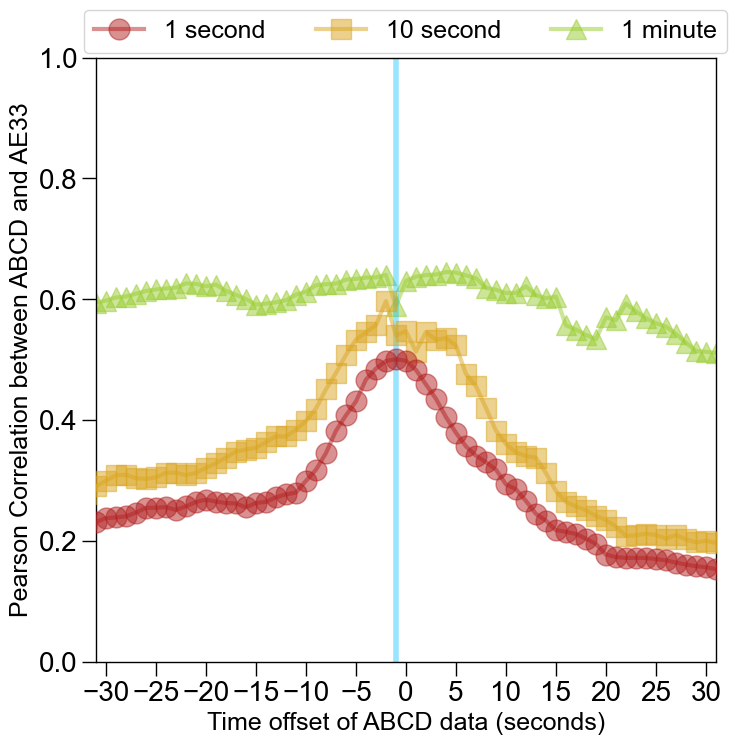

In [14]:
y = offset.loc[offset.pearsonHz.idxmax(),'delta']

fig, ax = plt.subplots(figsize=(8,8))
al = 0.5
al2 = 0.4
ax.plot(offset.delta,offset.pearsonHz,'o-',color = '#B22222',alpha = al,label = '1 second',zorder=5,ms=15)
ax.plot(offset.delta,offset.pearson10,'s-',color = '#DAA520',alpha = al,label = '10 second',zorder = 3,ms=15)
ax.plot(offset.delta,offset.pearsonM,'^-',color = '#9ACD32',alpha = al,label = '1 minute',ms=15)
ax.axvline(y,lw = 4,alpha = al2,color='#00BFFF')

ax.set_ylabel('Pearson Correlation between ABCD and AE33')
ax.set_xlabel('Time offset of ABCD data (seconds)')
ax.set_ylim([0,1])
ax.set_xlim([-31,31])
ax.legend(loc='upper center',bbox_to_anchor = (.5,1.1),ncol = 3)
ax.set_xticks(np.arange(-30,35,5))

path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/plots/peak match/'

#fig.savefig(path+'timeOffsetABCDvsAE33.png')

In [15]:
offset.loc[offset.pearsonHz.idxmax(),'delta']

-1.0

In [16]:
offset.loc[offset.pearson10.idxmax(),'delta']

-2.0

In [17]:
offset.loc[offset.pearsonM.idxmax(),'delta']

4.0

# Offsets of updated 1 Hz gas data

In [18]:
gasHz = pd.merge(NOx_hz[['datetime','NO (ppm)','NO2 (ppm)','Nox (ppm)']],CO_hz[['datetime','CO (ppm)']],on='datetime',how='outer')
gasHz = pd.merge(gasHz,CO2H_hz[['datetime','CO2 (ppm)']],on='datetime',how='outer')
gasHz = pd.merge(gasHz,CO2L_hz[['datetime','CO2 (ppm)']],on='datetime',how='outer',suffixes=('_h', '_l'))
gasHz = pd.merge(gasHz,dfs[['datetime','BC1','BC6']],on='datetime',how='outer')
gasHz = pd.merge(gasHz,ABCDhz[['datetime','BC']],on='datetime',how='outer')
gasHz = gasHz.set_index('datetime').sort_index().reset_index()

In [19]:
gascol = gasHz.columns.tolist()
gascol.remove('CO2 (ppm)_h')
gascol.remove('datetime')

In [20]:
offHz = pd.DataFrame(columns = gascol)
bound = 121
seconds = np.arange(0,bound)

#negative offset loop
for s in seconds:
    i=0
    for c in gascol:
        if c == 'BC':
            df_new = gasHz[['datetime',c]]
            mask = (df_new.BC > 1000) | (df_new.BC < -50)
            df_new[mask] = np.nan
        else:
            df_new = gasHz[['datetime',c]]
            
        dfco2 = gasHz[['datetime','CO2 (ppm)_h']]
        
        new_datetime = df_new.datetime - DateOffset(seconds = float(s))
            
        df_new.loc[:,'datetime'] = new_datetime
            
        df = pd.merge(df_new,dfco2,on='datetime',how='outer')
            
        p = pearson(df[c],df['CO2 (ppm)_h'])
        offHz.loc[-s,c] = p
        i+=1

    
#positive offset loop
seconds = np.arange(1,bound)
for s in seconds:
    i=0
    for c in gascol:
        if c == 'BC':
            df_new = gasHz[['datetime',c]]
            mask = (df_new.BC > 1000) | (df_new.BC < -50)
            df_new[mask] = np.nan
        else:
            df_new = gasHz[['datetime',c]]
            
        dfco2 = gasHz[['datetime','CO2 (ppm)_h']]
        
        new_datetime = df_new.datetime + DateOffset(seconds = float(s))
            
        df_new.loc[:,'datetime'] = new_datetime
            
        df = pd.merge(df_new,dfco2,on='datetime',how='outer')
            
        p = pearson(df[c],df['CO2 (ppm)_h'])
        offHz.loc[s,c] = p
        i+=1

offHz.sort_index(inplace=True)

/var/folders/ft/cvp8z_vj1m9gr24vdrsn17rw0000gn/T/ipykernel_5043/3015383471.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:,'datetime'] = new_datetime
/var/folders/ft/cvp8z_vj1m9gr24vdrsn17rw0000gn/T/ipykernel_5043/3015383471.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:,'datetime'] = new_datetime
/var/folders/ft/cvp8z_vj1m9gr24vdrsn17rw0000gn/T/ipykernel_5043/3015383471.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

## Plot

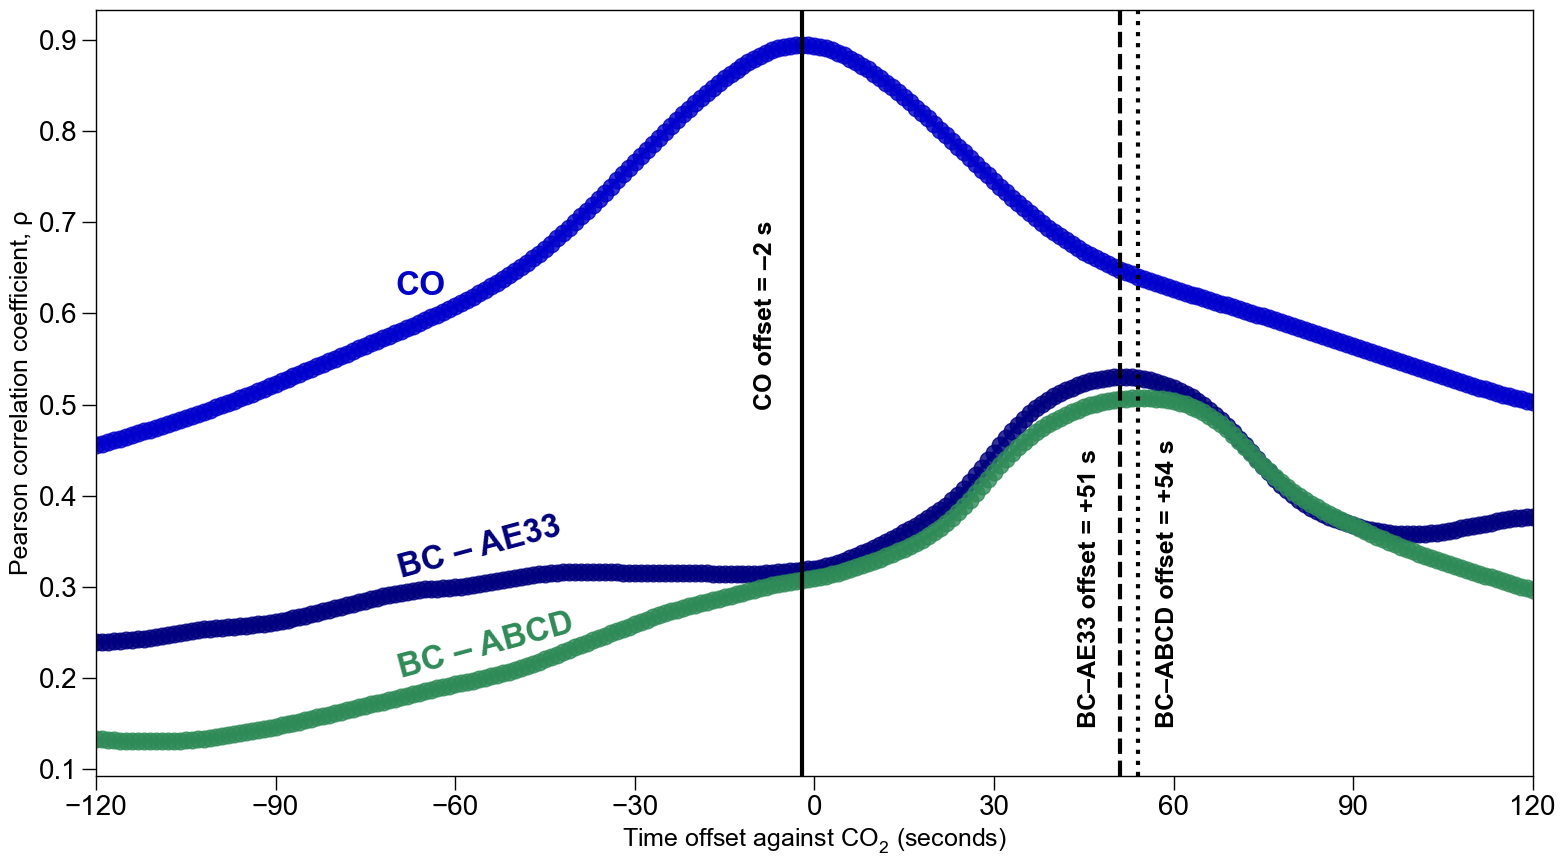

In [39]:
label3 = {'CO (ppm)':'CO [ppm]','BC6':'BC - AE33','BC':'BC - ABCD'}

co = '#0000CD'
co2 = '#DC143C'
BC6 = '#000080'
abcd = '#2E8B57'

fig,ax = plt.subplots(figsize=(16,9))

offHz.loc[:,['CO (ppm)','BC6','BC']].plot(ax = ax,style='o-',color = [co,BC6,abcd],alpha = 0.8,ms = 12,legend=False)
#ax.grid(True)
ax.set_xlabel('Time offset against CO$_2$ (seconds)')
ax.set_ylabel('Pearson correlation coefficient, ρ')
ax.set_xticks(np.arange(-120,150,30))
ax.set_xlim([-120,120])
#label2 = ['NO','NO$_2$','NO$_x$','CO','CO$_2$ LICOR','UV PM','BC - AE33','BC - ABCD']

CO_vert = ax.axvline(-2,lw=3,color='k',label = 'CO offset = -2 [sec]')
AE33_vert = ax.axvline(51,lw=3,color='k',ls='--',label = 'BC AE33 offset = +51 [sec]')
ABCD_vert = ax.axvline(54,lw=3,color='k',ls=':',label = 'BC ABCD offset = +54 [sec]')


ax.annotate('CO',(-70,0.62),color=co,fontweight='bold',fontsize=24)
ax.annotate('BC – AE33',(-70,0.31),color=BC6,fontweight='bold',fontsize=24,rotation=15)
ax.annotate('BC – ABCD',(-70,0.2),color=abcd,fontweight='bold',fontsize=24,rotation=15)

ax.annotate('CO offset = –2 s',(-10,0.5),rotation=90,fontweight='bold')
ax.annotate('BC–AE33 offset = +51 s',(44,0.15),rotation=90,fontweight='bold')
ax.annotate('BC–ABCD offset = +54 s',(57,0.15),rotation=90,fontweight='bold')

# add legend for vertical lines
# handles,labels = ax.get_legend_handles_labels()
# labels[0] = 'CO'
# labels[1] = 'BC AE33'
# labels[2] = 'BC ABCD'
# ax.legend(handles,labels,fontsize=30,loc='upper right',bbox_to_anchor=(1.4,0.65))

fig.tight_layout()

path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/clean plots/'
#fig.savefig(path+'1Hz_alignment_alldata.png')

In [34]:
for c in offHz.columns:
    offHz[c] = pd.to_numeric(offHz[c])
    print(c+' offset: {:.2f} seconds'.format(offHz[c].idxmax()))

NO (ppm) offset: -39.00 seconds
NO2 (ppm) offset: -57.00 seconds
Nox (ppm) offset: -42.00 seconds
CO (ppm) offset: -2.00 seconds
CO2 (ppm)_l offset: 29.00 seconds
BC1 offset: 51.00 seconds
BC6 offset: 51.00 seconds
BC offset: 54.00 seconds


# Check alignment of data with burn timeseries

## ABCD and AE33 unaligned

In [43]:
dfBC = pd.merge(ABCDhz[['datetime','ATN','BC']],dfs[['datetime','BC6']],on='datetime',how='outer')
dfBC.set_index('datetime',inplace=True)

mask = (dfBC.BC < -50) | (dfBC.BC > 1000)
dfBC.BC.loc[mask] = np.nan

dfBC.sort_index(inplace=True)

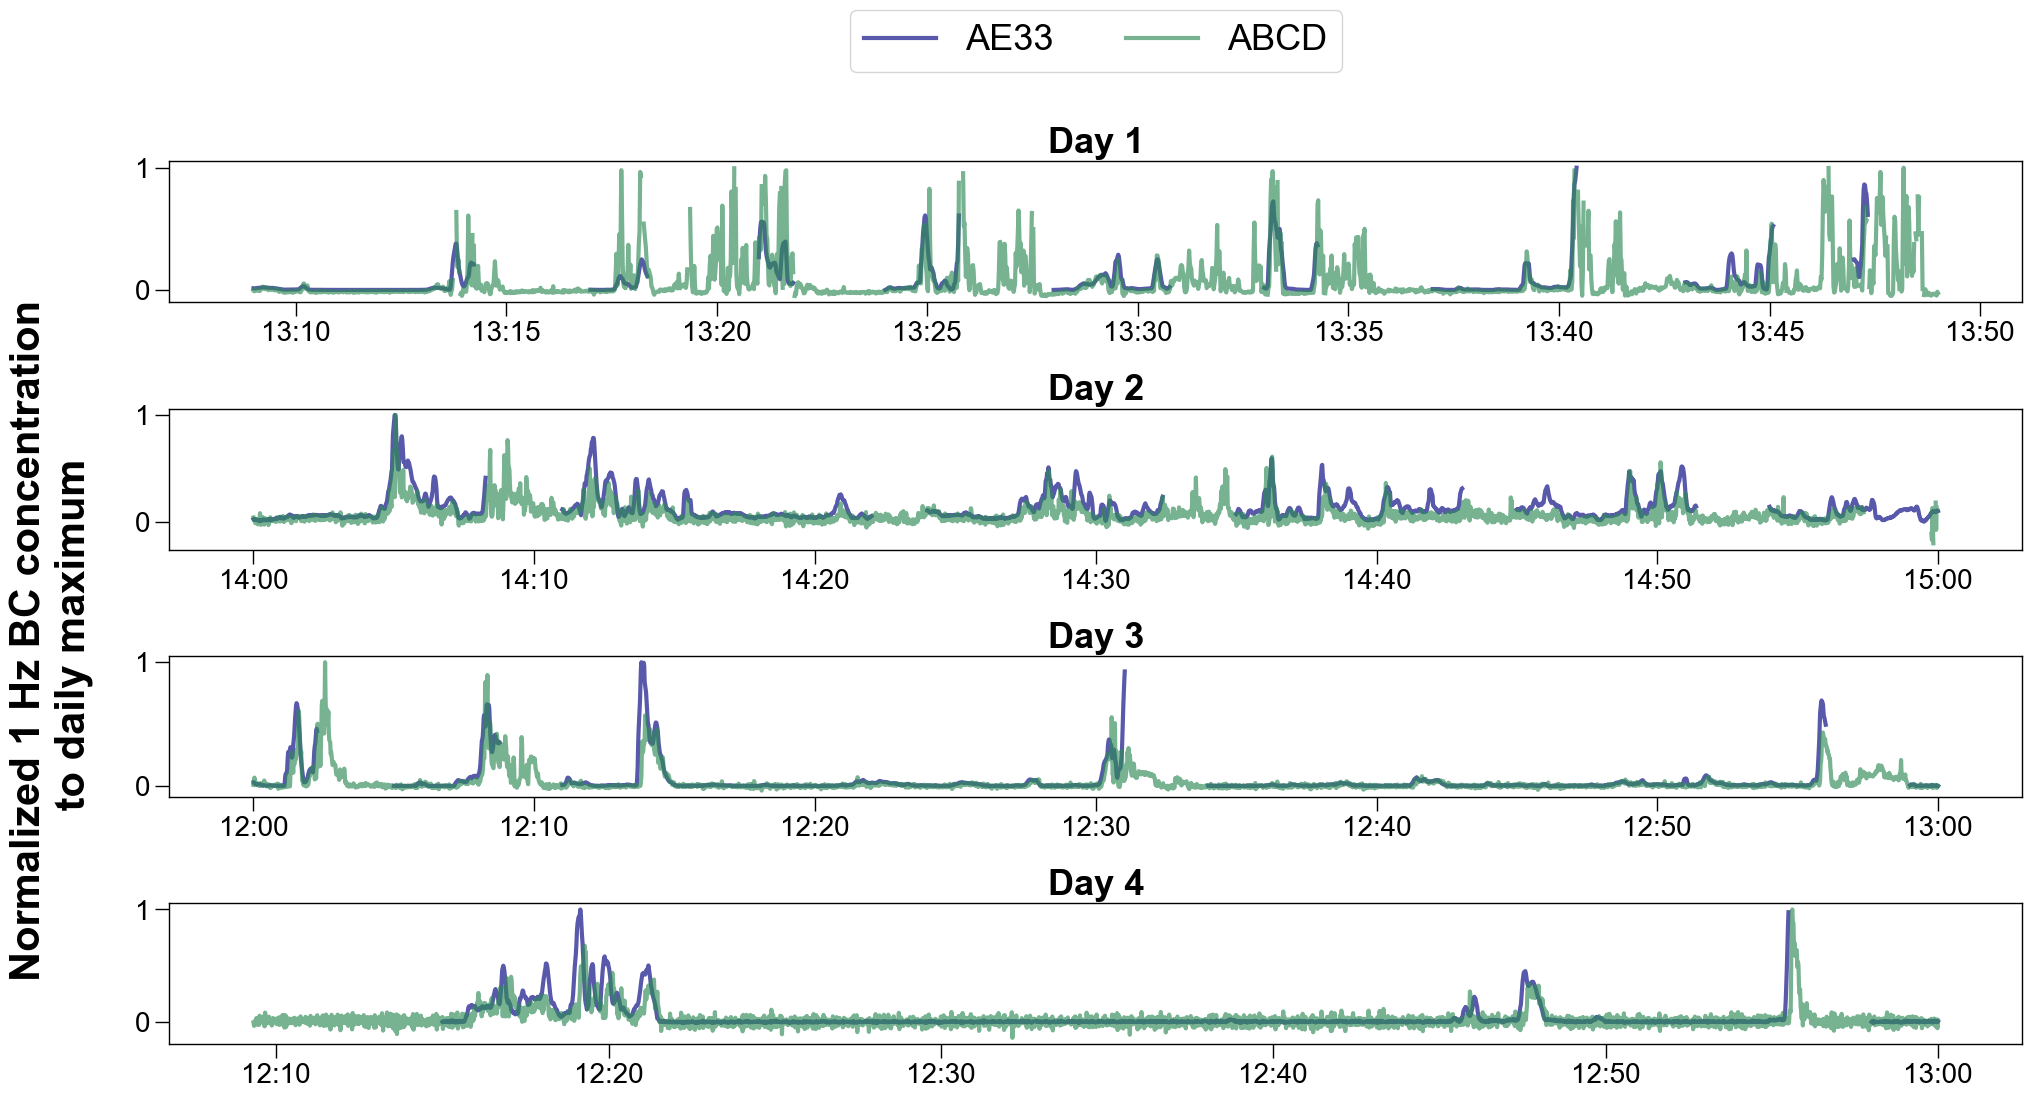

In [44]:
fig,ax = plt.subplots(4)
al = 0.65
#day 1 
df = dfBC.loc[pd.Timestamp('2021-04-20 13:09'):pd.Timestamp('2021-04-20 13:49')]

ax[0].plot(df.index,df.BC6 / df.BC6.max(),'-',c = BC6,alpha = al,label = 'AE33')
ax[0].plot(df.index,df.BC / df.BC.max(),'-',c=abcd,alpha=al,label='ABCD')

ax[0].set_title('Day 1',fontweight='bold',fontsize = 26)
ax[0].legend(bbox_to_anchor =(0.5,2.2),loc='upper center', fontsize = 26,ncol = 4)
ax[0].xaxis.set_major_formatter(timeFormat)

#day 2
df = dfBC.loc[pd.Timestamp('2021-04-21 14:00'):pd.Timestamp('2021-04-21 15:00')]

ax[1].plot(df.index,df.BC6 / df.BC6.max(),'-',c = BC6,alpha = al)
ax[1].plot(df.index,df.BC / df.BC.max(),'-',c=abcd,alpha=al,label='ABCD')

ax[1].set_title('Day 2',fontweight='bold',fontsize = 26)
ax[1].xaxis.set_major_formatter(timeFormat)

#day 3
df = dfBC.loc[pd.Timestamp('2021-04-22 12:00'):pd.Timestamp('2021-04-22 13:00')]

ax[2].plot(df.index,df.BC6 / df.BC6.max(),'-',c = BC6,alpha = al)
ax[2].plot(df.index,df.BC / df.BC.max(),'-',c=abcd,alpha=al,label='ABCD')

ax[2].set_title('Day 3',fontweight = 'bold',fontsize = 26)
ax[2].xaxis.set_major_formatter(timeFormat)

#day 4
df = dfBC.loc[pd.Timestamp('2021-04-23 12:00'):pd.Timestamp('2021-04-23 13:00'),:]

ax[3].plot(df.index,df.BC6 / df.BC6.max(),'-',c = BC6,alpha = al)
ax[3].plot(df.index,df.BC / df.BC.max(),'-',c=abcd,alpha=al,label='ABCD')

ax[3].set_title('Day 4',fontweight = 'bold',fontsize = 26)
ax[3].xaxis.set_major_formatter(timeFormat)

fig.text(0.001, 0.12, 'Normalized 1 Hz BC concentration\n to daily maximum', ha='center',rotation='vertical',fontsize = 30,fontweight = 'bold')
fig.tight_layout()
plt.gcf().subplots_adjust(left=0.06)

path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/plots/peak match/'
fig.savefig(path + 'AE33notaligned_ABCDnotAligned.png')

## ABCD and AE33 aligned

In [46]:
# run once
# save aligned dataframes here

# reload dataframes
folder = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/aligned CSV'

AE33a = pd.read_csv(folder+'/ground_AE33_1Hz_align_sampleonly.csv')
ABCDa = pd.read_csv(folder+'/ground_ABCD_1Hz_align.csv')
ABCDa.drop('Unnamed: 0',axis=1,inplace=True)
AE33a.drop('Unnamed: 0',axis=1,inplace=True)

AE33a.datetime = pd.to_datetime(AE33a.datetime)
ABCDa.datetime = pd.to_datetime(ABCDa.datetime)

In [47]:
dfBCa = pd.merge(ABCDa[['datetime','ATN','BC']],AE33a[['datetime','BC6']],on='datetime',how='outer')
dfBCa.set_index('datetime',inplace=True)

mask = (dfBCa.BC < -50) | (dfBCa.BC > 1000)
dfBCa.BC.loc[mask] = np.nan

dfBCa.sort_index(inplace=True)

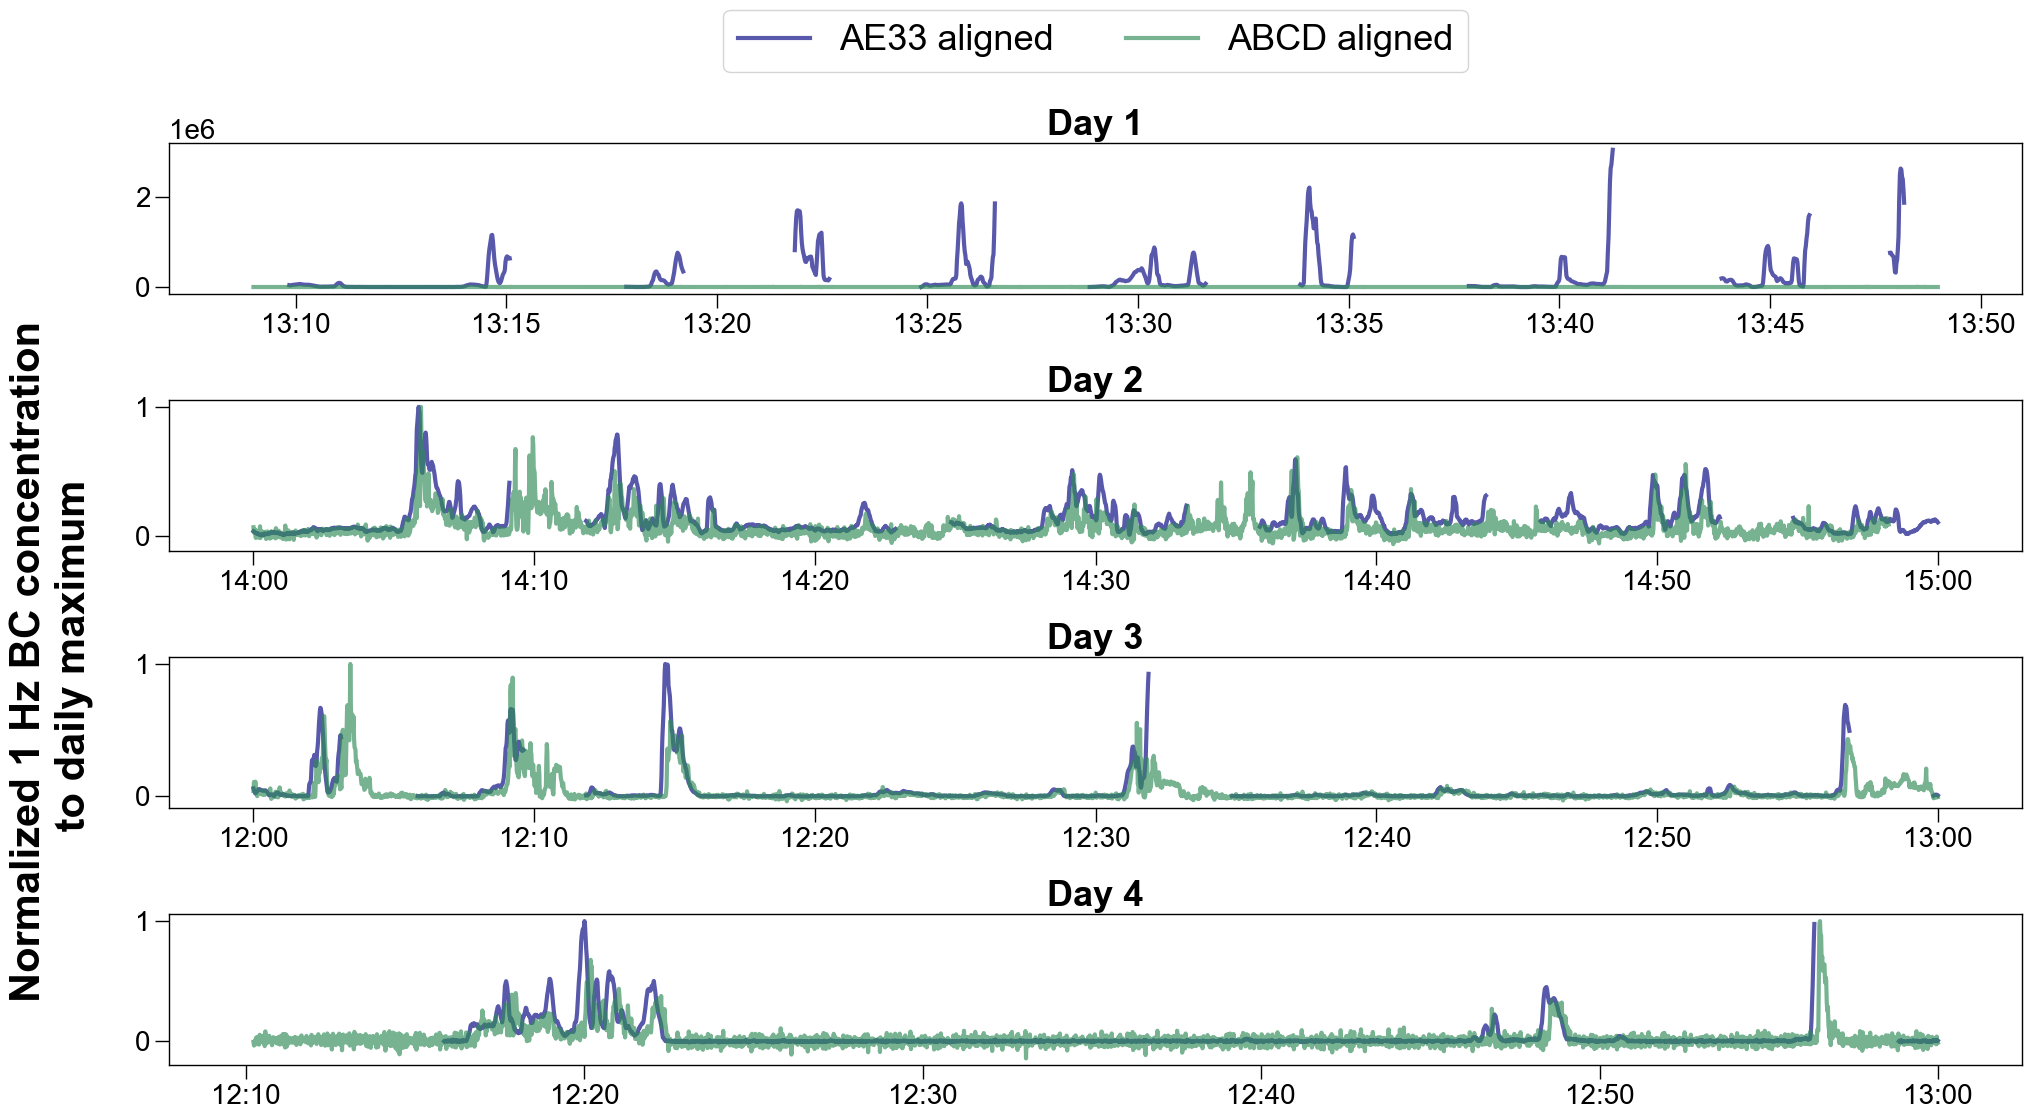

In [73]:
fig,ax = plt.subplots(4)
al = 0.65
#day 1 
df = dfBCa.loc[pd.Timestamp('2021-04-20 13:09'):pd.Timestamp('2021-04-20 13:49')]

ax[0].plot(df.index,df.BC6,'-',c = BC6,alpha = al,label = 'AE33 aligned')
ax[0].plot(df.index,df.BC,'-',c=abcd,alpha=al,label='ABCD aligned')

ax[0].set_title('Day 1',fontweight='bold',fontsize = 26)
ax[0].legend(bbox_to_anchor =(0.5,2),loc='upper center', fontsize = 26,ncol = 4)
ax[0].xaxis.set_major_formatter(timeFormat)

#day 2
df = dfBCa.loc[pd.Timestamp('2021-04-21 14:00'):pd.Timestamp('2021-04-21 15:00')]

ax[1].plot(df.index,df.BC6 / df.BC6.max(),'-',c = BC6,alpha = al)
ax[1].plot(df.index,df.BC / df.BC.max(),'-',c=abcd,alpha=al,label='ABCD')

ax[1].set_title('Day 2',fontweight='bold',fontsize = 26)
ax[1].xaxis.set_major_formatter(timeFormat)

#day 3
df = dfBCa.loc[pd.Timestamp('2021-04-22 12:00'):pd.Timestamp('2021-04-22 13:00')]

ax[2].plot(df.index,df.BC6 / df.BC6.max(),'-',c = BC6,alpha = al)
ax[2].plot(df.index,df.BC / df.BC.max(),'-',c=abcd,alpha=al,label='ABCD')

ax[2].set_title('Day 3',fontweight = 'bold',fontsize = 26)
ax[2].xaxis.set_major_formatter(timeFormat)

#day 4
df = dfBCa.loc[pd.Timestamp('2021-04-23 12:00'):pd.Timestamp('2021-04-23 13:00'),:]

ax[3].plot(df.index,df.BC6 / df.BC6.max(),'-',c = BC6,alpha = al)
ax[3].plot(df.index,df.BC / df.BC.max(),'-',c=abcd,alpha=al,label='ABCD')

ax[3].set_title('Day 4',fontweight = 'bold',fontsize = 26)
ax[3].xaxis.set_major_formatter(timeFormat)

fig.text(0.001, 0.12, 'Normalized 1 Hz BC concentration\n to daily maximum', ha='center',rotation='vertical',fontsize = 30,fontweight = 'bold')
fig.tight_layout()
plt.gcf().subplots_adjust(left=0.06)

path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/plots/peak match/'
#fig.savefig(path+'AE33aligned_ABCDaligned.png')

## alignment 1 Hz all data

### unaligned

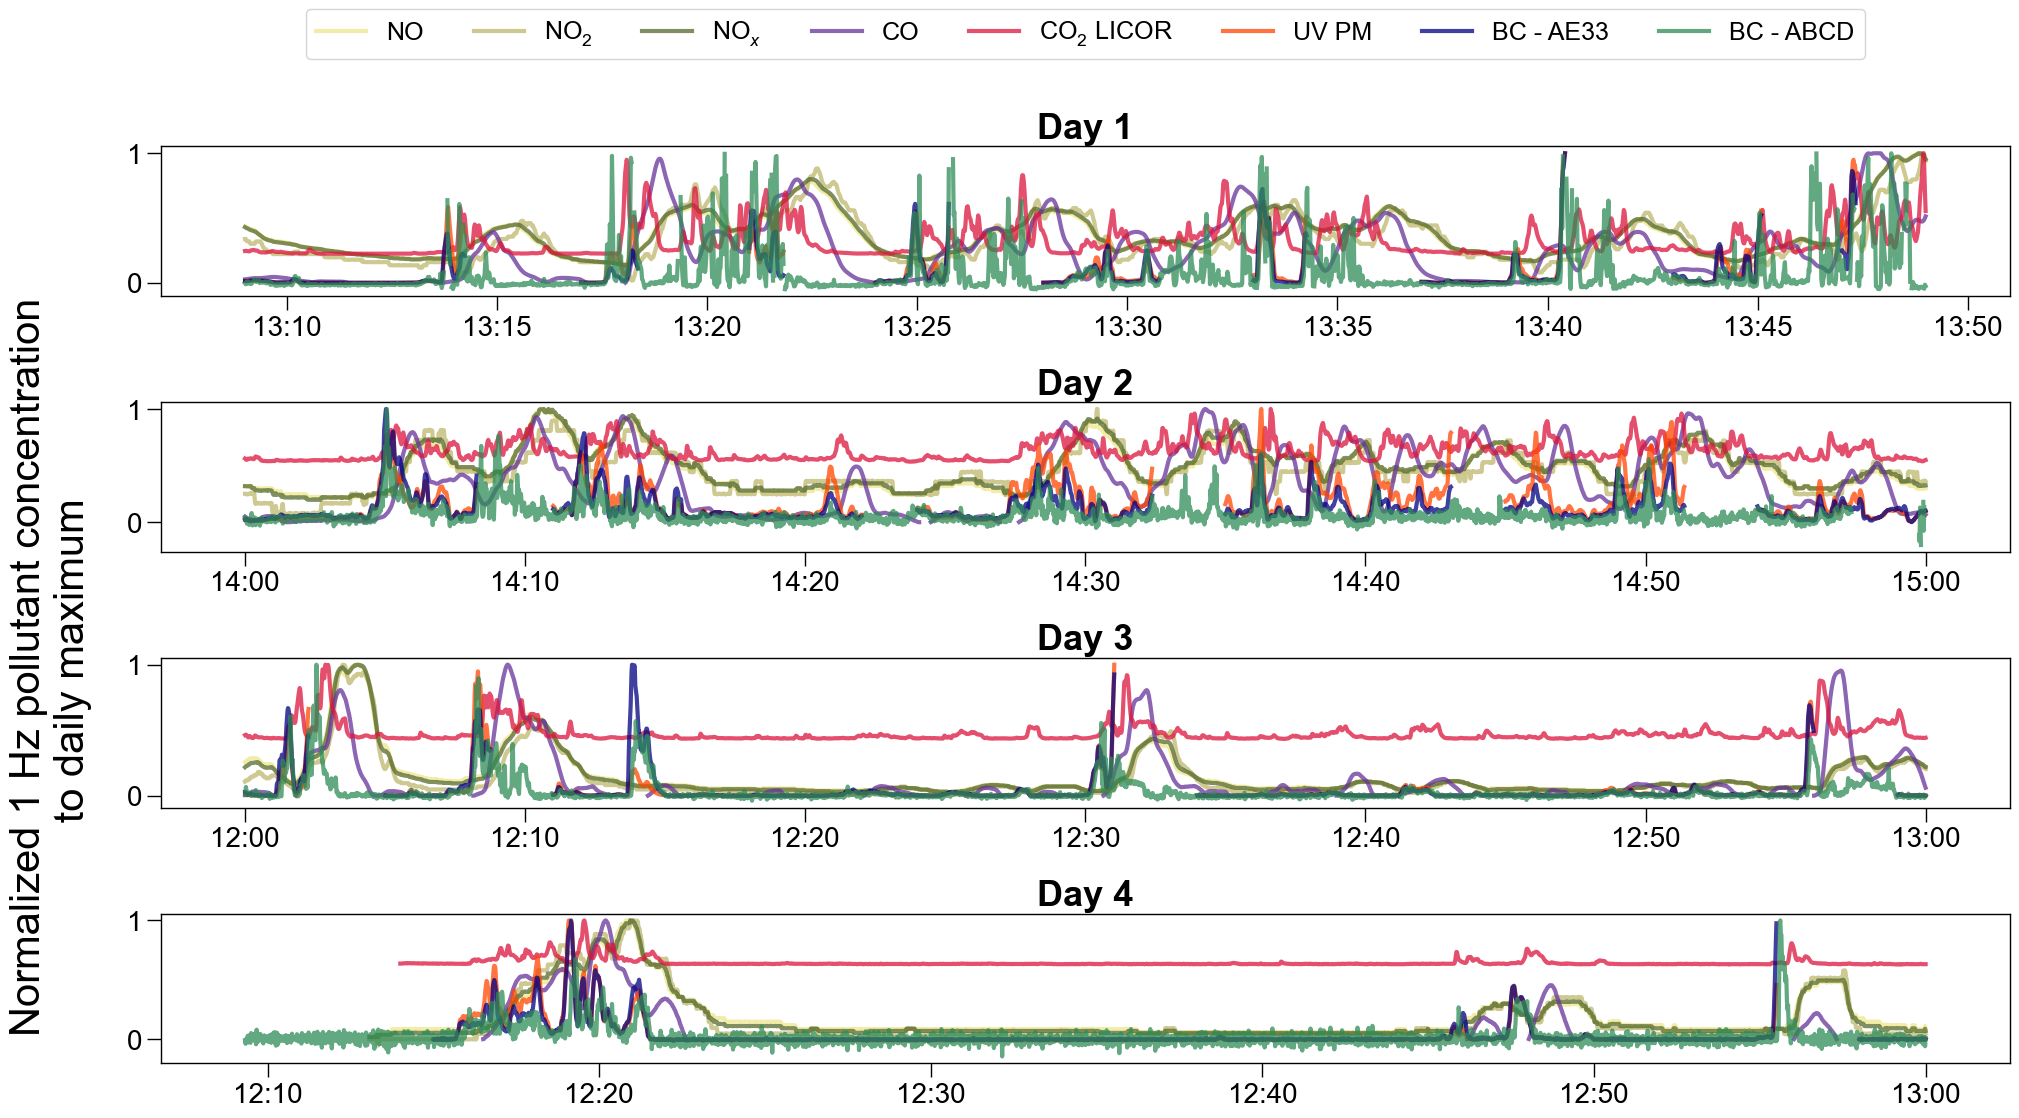

In [74]:
# colors
uv = '#FF4500'
no = '#F0E68C'
no2 = '#BDB76B'
nox = '#556B2F'
co = '#663399'
co2 = '#DC143C'

colors = [no,no2,nox,co,co2,uv,BC6,abcd]
label2 = ['NO','NO$_2$','NO$_x$','CO','CO$_2$ LICOR','UV PM','BC - AE33','BC - ABCD']
gasDT = gasHz.set_index('datetime')
al = 0.75

mask = (gasDT.BC < -50) | (gasDT.BC > 1000)
gasDT.BC.loc[mask] = np.nan



fig,ax = plt.subplots(4)

#day 1 
df = gasDT.loc[pd.Timestamp('2021-04-20 13:09'):pd.Timestamp('2021-04-20 13:49')]

for i,c in enumerate(gascol):
    ax[0].plot(df.index,df[c]/df[c].max(),'-',alpha = al,c=colors[i],label=label2[i])

ax[0].set_title('Day 1',fontweight='bold',fontsize = 26)
ax[0].legend(bbox_to_anchor =(0.5,2),loc='upper center', fontsize = 18,ncol = 8)
ax[0].xaxis.set_major_formatter(timeFormat)

#day 2
df = gasDT.loc[pd.Timestamp('2021-04-21 14:00'):pd.Timestamp('2021-04-21 15:00')]

for i,c in enumerate(gascol):
    ax[1].plot(df.index,df[c]/df[c].max(),'-',alpha = al,c=colors[i],label=label2[i])

ax[1].set_title('Day 2',fontweight='bold',fontsize = 26)
ax[1].xaxis.set_major_formatter(timeFormat)

#day 3
df = gasDT.loc[pd.Timestamp('2021-04-22 12:00'):pd.Timestamp('2021-04-22 13:00')]

for i,c in enumerate(gascol):
    ax[2].plot(df.index,df[c]/df[c].max(),'-',alpha = al,c=colors[i],label=label2[i])

ax[2].set_title('Day 3',fontweight = 'bold',fontsize = 26)
ax[2].xaxis.set_major_formatter(timeFormat)

#day 4
df = gasDT.loc[pd.Timestamp('2021-04-23 12:00'):pd.Timestamp('2021-04-23 13:00'),:]

for i,c in enumerate(gascol):
    ax[3].plot(df.index,df[c]/df[c].max(),'-',alpha = al,c=colors[i],label=label2[i])

ax[3].set_title('Day 4',fontweight = 'bold',fontsize = 26)
ax[3].xaxis.set_major_formatter(timeFormat)

fig.text(0.005, 0.09, 'Normalized 1 Hz pollutant concentration\n to daily maximum', ha='center',rotation='vertical',fontsize = 30)
fig.tight_layout()
plt.gcf().subplots_adjust(left=0.06)

path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/plots/peak match/'
#fig.savefig('gas&BC_unaligned.png')

### aligned 

In [75]:
path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/aligned CSV/'
align = pd.read_csv(path+'aligned_1Hz_gas&BC_06-08-2022.csv')
align.datetime = pd.to_datetime(align.datetime)
align.set_index('datetime',inplace=True)

In [77]:
gas = align.columns[:-3].tolist()
element_remove = ['ATN','CO2 (ppm)','Temperature(°C)','Pressure(Pa)','Status','RH','Temp','BC','BC_c']

for element in element_remove:
    gas.remove(element)
    
gas

['CO (ppm)', 'CO2 LICOR', 'NO (ppm)', 'NO2 (ppm)', 'Nox (ppm)', 'BC1', 'BC6']

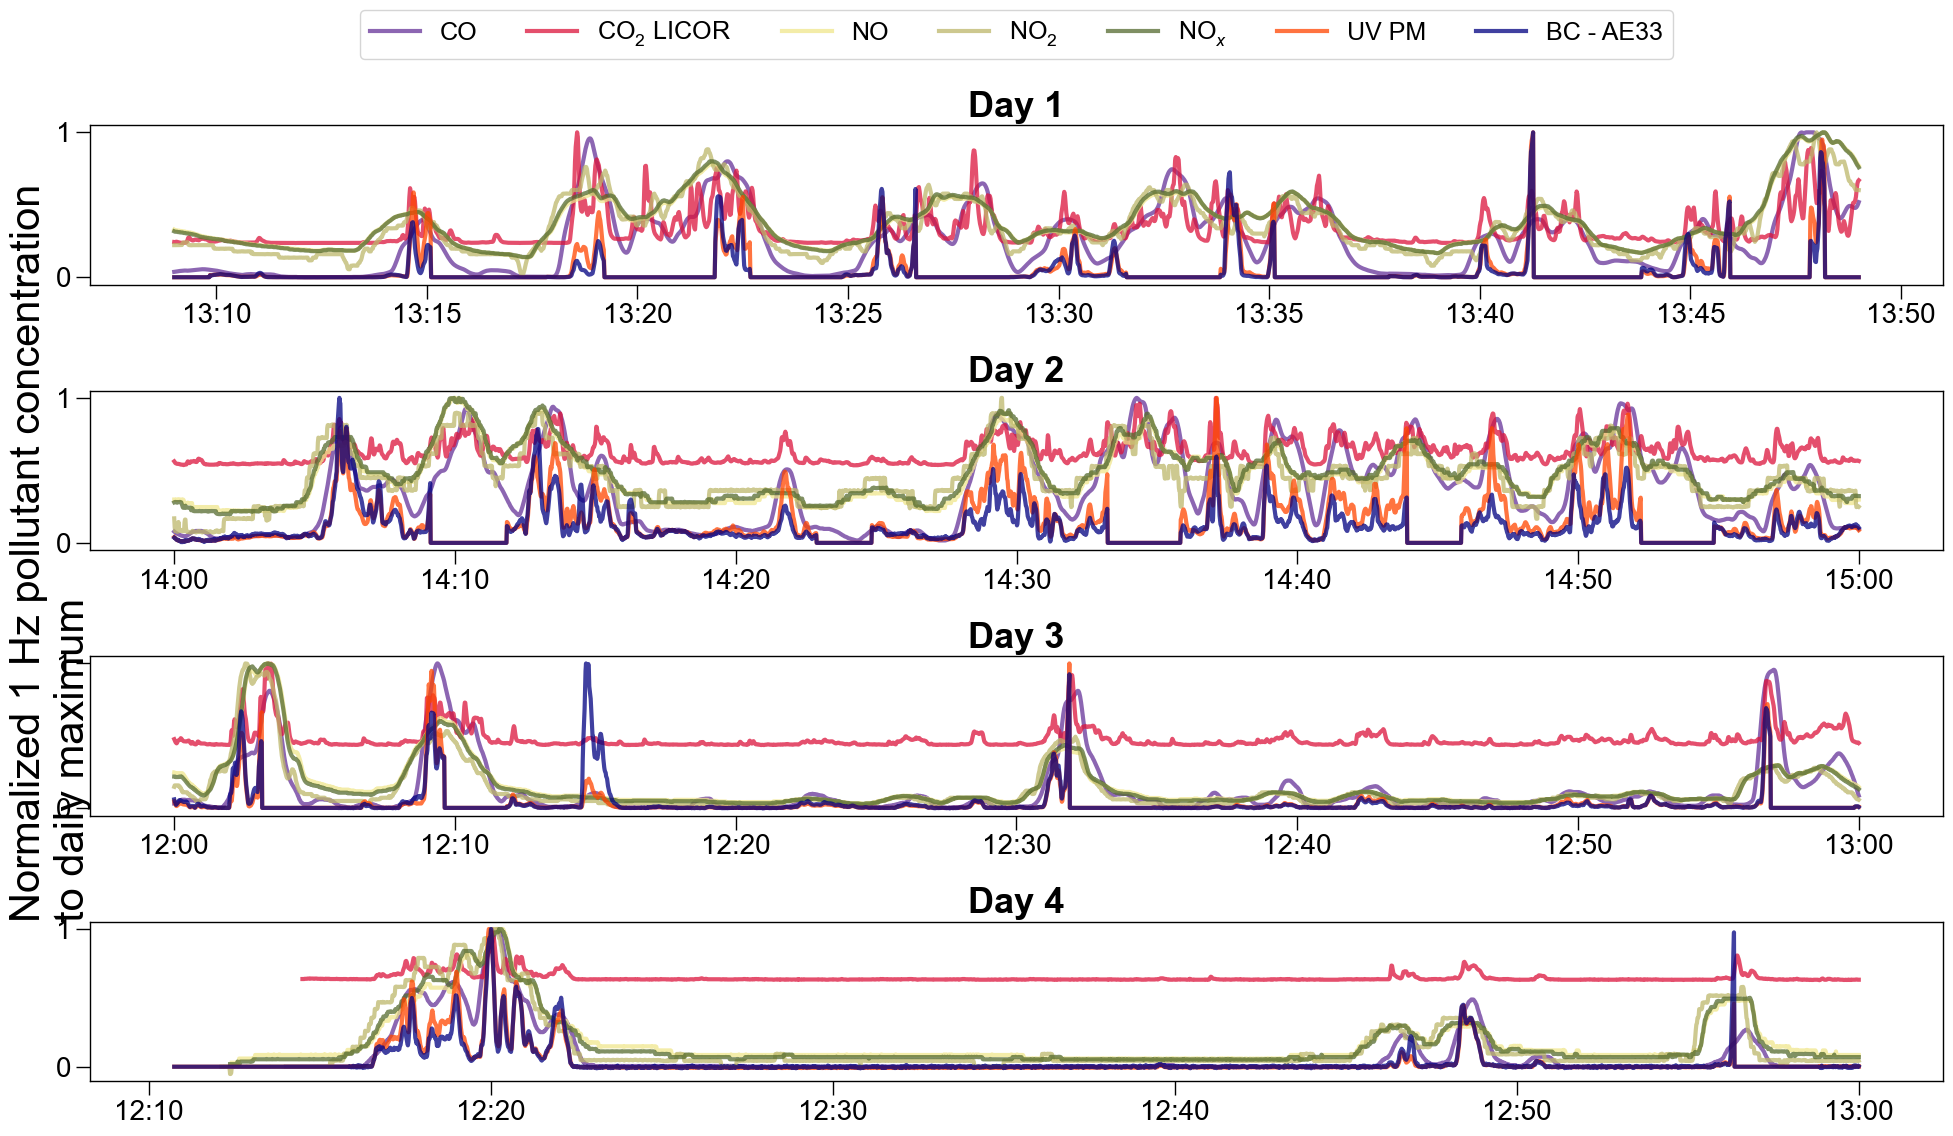

In [85]:
colors = [co,co2,no,no2,nox,uv,BC6,abcd]
label2 = ['CO','CO$_2$ LICOR','NO','NO$_2$','NO$_x$','UV PM','BC - AE33','BC - ABCD']
al = 0.75

mask = (align.BC < -50) | (align.BC > 1000)
align.BC.loc[mask] = np.nan

fig,ax = plt.subplots(4)

#day 1 
df = align.loc[pd.Timestamp('2021-04-20 13:09'):pd.Timestamp('2021-04-20 13:49')]

for i,c in enumerate(gas):
    ax[0].plot(df.index,df[c]/df[c].max(),'-',alpha = al,c=colors[i],label=label2[i])

ax[0].set_title('Day 1',fontweight='bold',fontsize = 26)
ax[0].legend(bbox_to_anchor =(0.5,1.8),loc='upper center', fontsize = 18,ncol = 8)
ax[0].xaxis.set_major_formatter(timeFormat)

#day 2
df = align.loc[pd.Timestamp('2021-04-21 14:00'):pd.Timestamp('2021-04-21 15:00')]

for i,c in enumerate(gas):
    ax[1].plot(df.index,df[c]/df[c].max(),'-',alpha = al,c=colors[i],label=label2[i])

ax[1].set_title('Day 2',fontweight='bold',fontsize = 26)
ax[1].xaxis.set_major_formatter(timeFormat)

#day 3
df = align.loc[pd.Timestamp('2021-04-22 12:00'):pd.Timestamp('2021-04-22 13:00')]

for i,c in enumerate(gas):
    ax[2].plot(df.index,df[c]/df[c].max(),'-',alpha = al,c=colors[i],label=label2[i])

ax[2].set_title('Day 3',fontweight = 'bold',fontsize = 26)
ax[2].xaxis.set_major_formatter(timeFormat)

#day 4
df = align.loc[pd.Timestamp('2021-04-23 12:00'):pd.Timestamp('2021-04-23 13:00'),:]

for i,c in enumerate(gas):
    ax[3].plot(df.index,df[c]/df[c].max(),'-',alpha = al,c=colors[i],label=label2[i])

ax[3].set_title('Day 4',fontweight = 'bold',fontsize = 26)
ax[3].xaxis.set_major_formatter(timeFormat)

#fig.text(0.03, 0.03, 'Normalized 1 Hz pollutant concentration\n to daily maximum', ha='center',rotation='vertical',fontsize = 30)
fig.supylabel('Normalized 1 Hz pollutant concentration\nto daily maximum', fontsize=30)
fig.tight_layout()
plt.gcf().subplots_adjust(left=0.06)

path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/plots/peak match/'
#fig.savefig(path+'gas&BC_aligned.png')

In [80]:
import statsmodels as sm

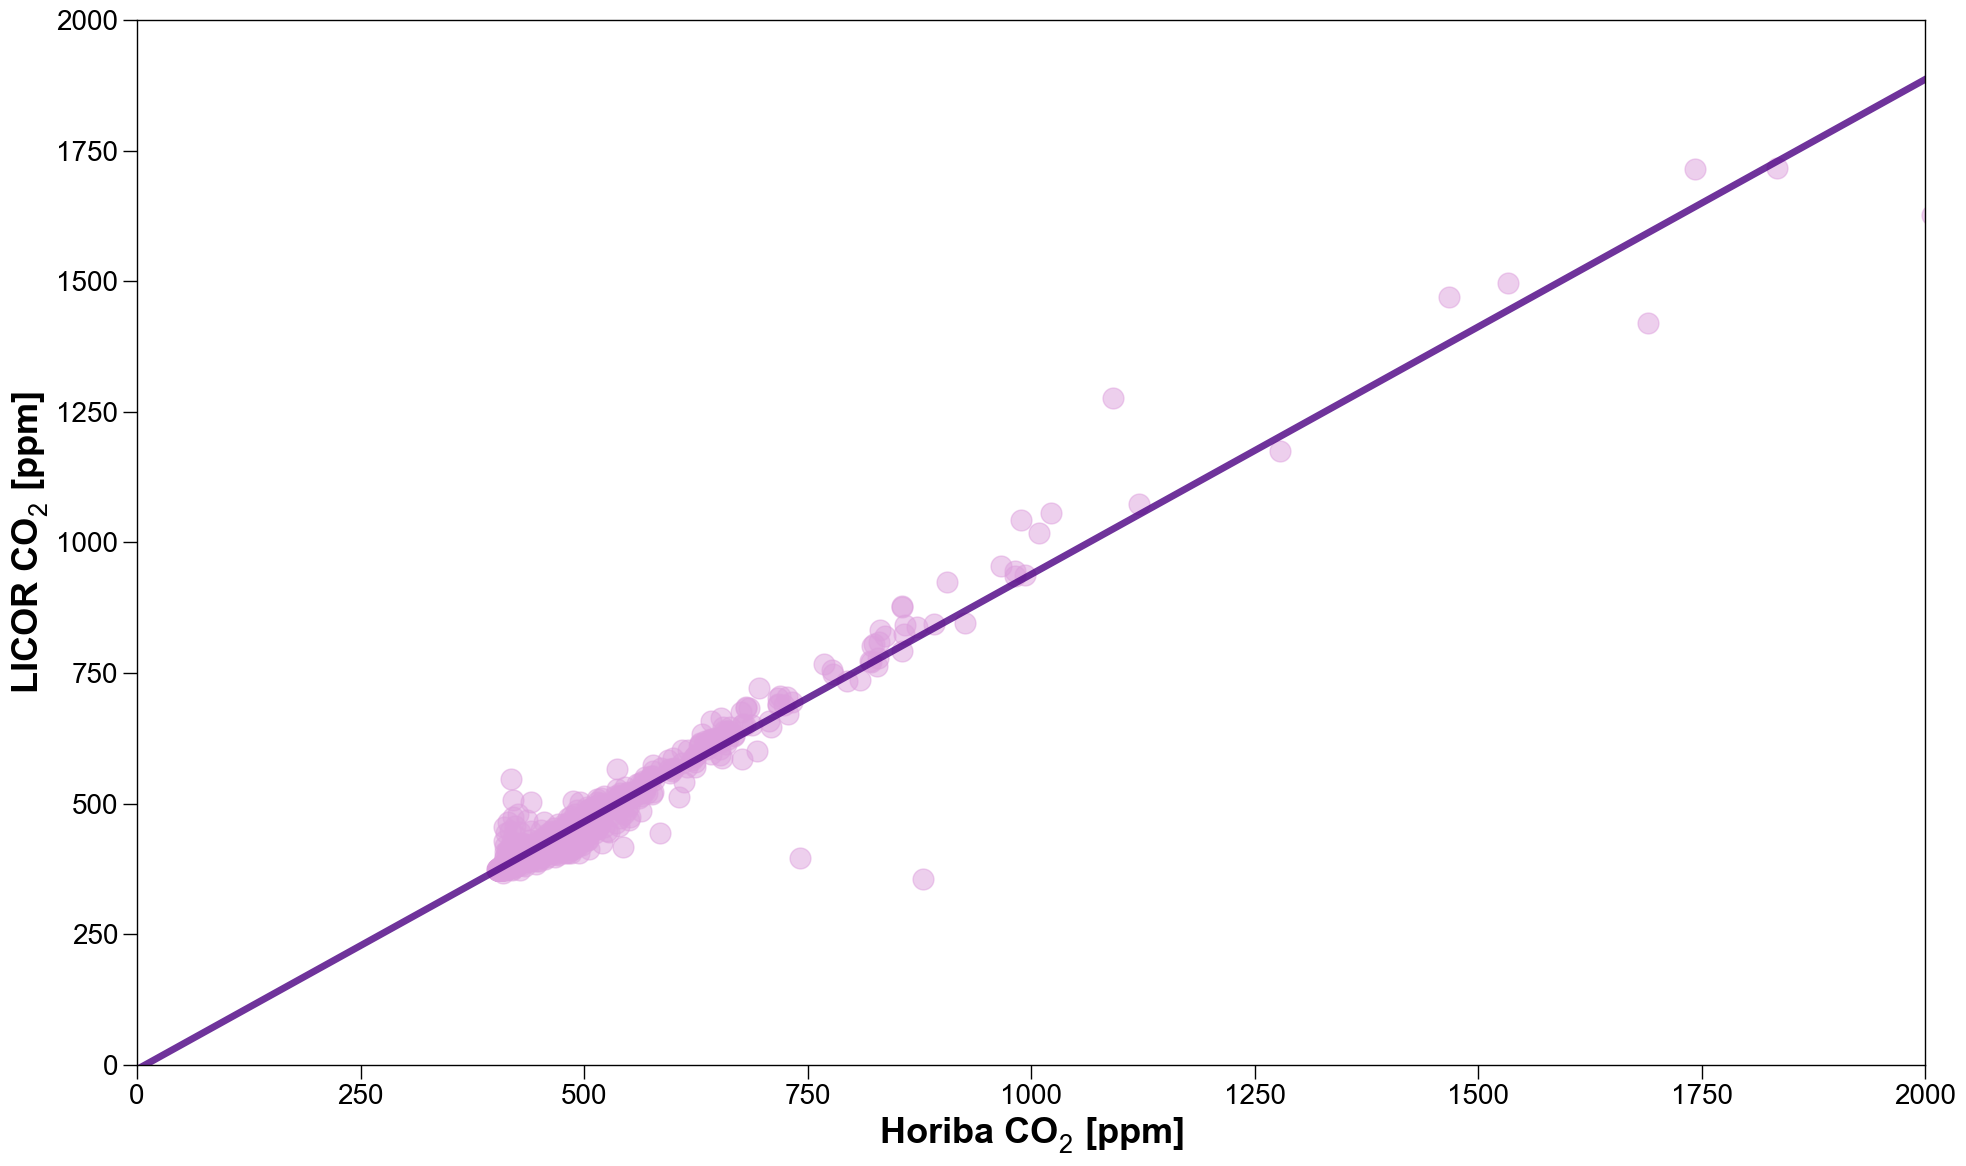

In [88]:
align_min = align[['CO2 (ppm)','CO2 LICOR']].resample('1T').mean()

s,b,r2,sl,su,bl,bu = linRegConstCI(align_min['CO2 (ppm)'],align_min['CO2 LICOR'])
x = np.arange(0,2000)

fig,ax = plt.subplots()

ax.plot(align_min['CO2 (ppm)'],align_min['CO2 LICOR'],'o',ms=15,alpha = 0.5,color='#DDA0DD')
ax.plot(x,x*s+b,'-',color = '#4B0082',lw=5,alpha=0.8)
ax.set_xlim([0,2000])
ax.set_ylim([0,2000])
#ax.axvline(CO2_b)
#ax.axhline(CO2_b)
ax.set_xlabel('Horiba CO$_2$ [ppm]',fontsize=26,fontweight='bold')
ax.set_ylabel('LICOR CO$_2$ [ppm]',fontsize=26,fontweight='bold')

fig.tight_layout()

path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/plots/peak match/'
fig.savefig(path+'Horiba_vs_LICOR.png')

In [89]:
CO_b = 1.6573625123816424
CO2_b = 411.32130965593785